#  Forecasting taxi orders

The taxi company has collected historical data on taxi orders at airports. To attract more drivers during the peak period, you need to predict the number of taxi orders for the next hour. Build a model for such a prediction.

The value of the *RMSE* metric on the test set should not exceed 48.

You need:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.


The data is in the `taxi.csv` file. The number of orders is in the `num_orders` column.


## Data Preparation

In [1]:
#!pip install sktime
#!pip install catboost
#!pip install fbprophet
#!pip install prophet -U
#!pip uninstall statsmodels
#!pip install pandas --upgrade pandas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import pmdarima as pm
from fbprophet import Prophet


Bad key text.latex.preview in file /Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_

## Анализ

In [3]:
df = pd.read_csv('/Users/vasily/Learning/Data Analytics/Projects/Taxi prediction/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df.sort_index(inplace=True)

In [5]:
print(df.index.is_monotonic)
print(df.index.min(),df.index.max())
df.head(5)
df.info()

True
2018-03-01 00:00:00 2018-08-31 23:50:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df = df.resample('1H').sum()
df.head(5)
data = df.copy()

Let's visualize the **trend** and **seasonal** components of the time series

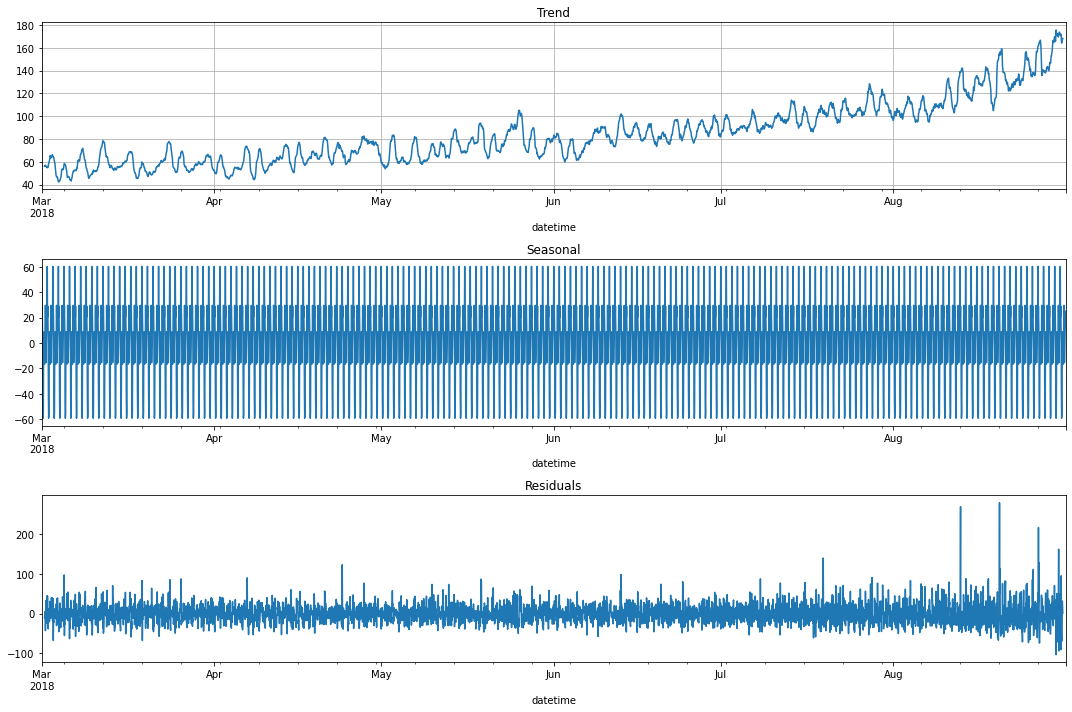

In [7]:
decomposed = seasonal_decompose(df)

def plot_decomposition(decomposed):
    plt.figure(figsize=(15,10))
    plt.subplot(311)
    decomposed.trend.plot(ax=plt.gca(), grid=True)
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonal')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()
plot_decomposition(decomposed)

Let's look at the chart for one month

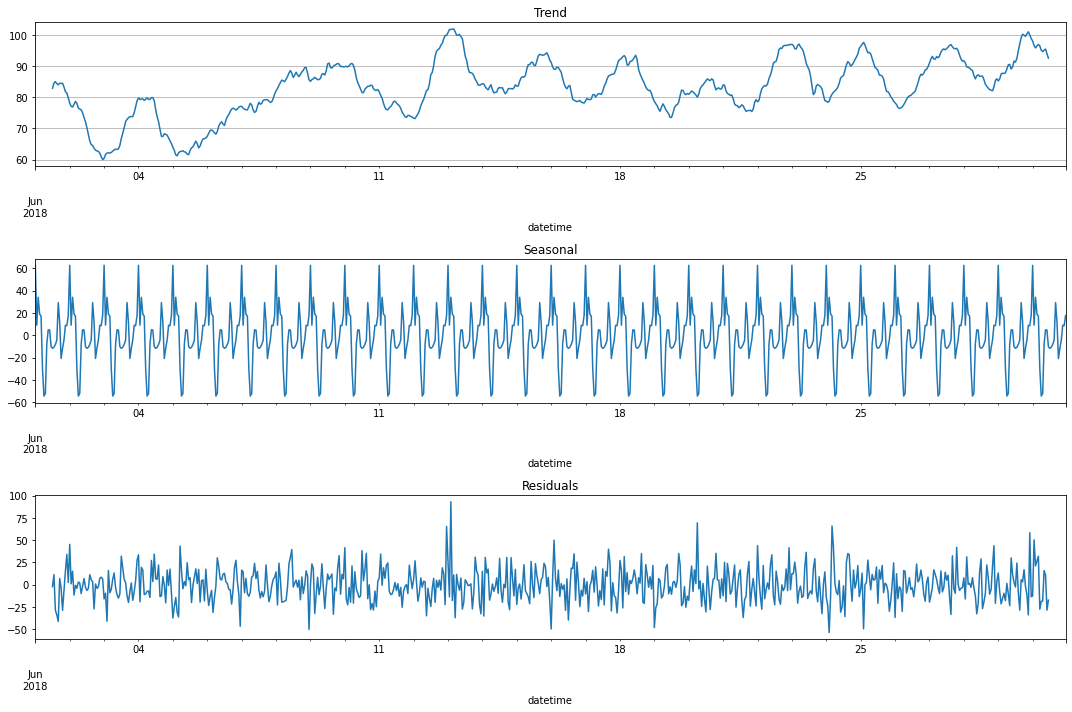

In [8]:
decomposed = seasonal_decompose(df['2018-06-01': '2018-06-30'])
plot_decomposition(decomposed)

In the time series under consideration, there is a pronounced daily seasonal component - the taxi load depends on the time of day. The trend component shows a smooth increase in orders throughout the entire time series, as well as fluctuations during the week and an increase in orders at the end of the week.
To predict such a time series, it will be useful to use the values for the last 24 hours and 7 days before as a feature.

The ACF (Auto-correlation Function) and PACF (Partial Auto-correlation Function) graphs below also indicate the 24 and 168 hour intervals.

/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Text(0.5, 1.0, 'PCF')

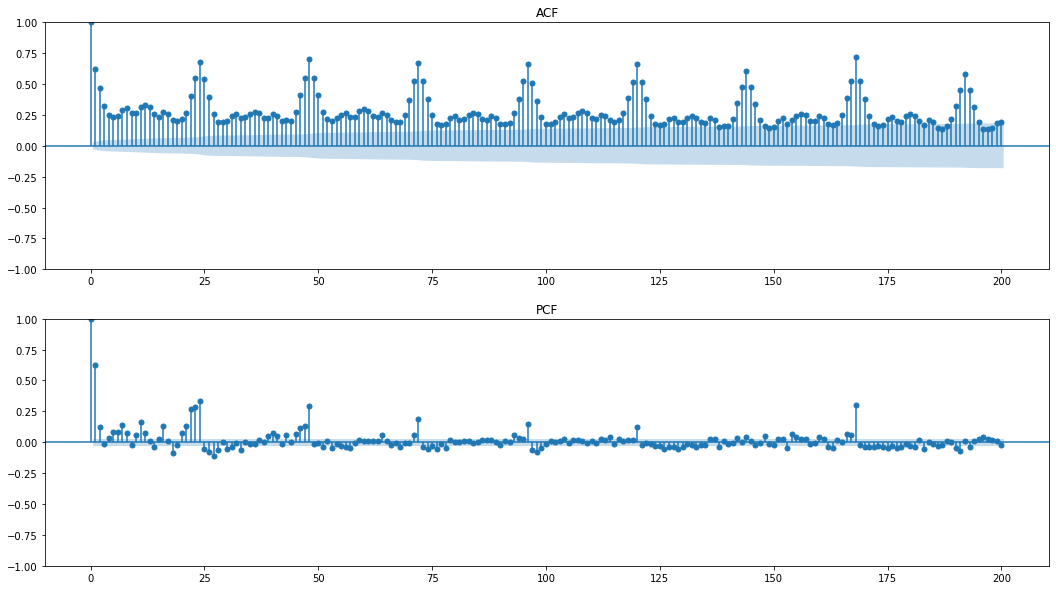

In [9]:
plt.figure(figsize=(18,10))
plt.subplot(211)
plot_acf(data['num_orders'], lags=200, use_vlines=True, ax=plt.gca())
plt.title('ACF')
plt.subplot(212)
plot_pacf(data['num_orders'], lags=200, use_vlines=True, ax=plt.gca())
plt.title('PCF')

In [10]:
#Adding features to the dataset
def make_features(data, max_lag=[0], additional_lags=[], rolling_mean_size=0):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    for lag in additional_lags:
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    if rolling_mean_size > 0:
        data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    
make_features(data, 24, [168], 240)
data = data.dropna()
print(data.head(10))

                     num_orders  day  dayofweek  lag_1  lag_2  lag_3  lag_4  \
datetime                                                                      
2018-03-11 00:00:00          81   11          6   73.0   80.0   62.0   54.0   
2018-03-11 01:00:00          83   11          6   81.0   73.0   80.0   62.0   
2018-03-11 02:00:00          36   11          6   83.0   81.0   73.0   80.0   
2018-03-11 03:00:00          49   11          6   36.0   83.0   81.0   73.0   
2018-03-11 04:00:00          30   11          6   49.0   36.0   83.0   81.0   
2018-03-11 05:00:00          11   11          6   30.0   49.0   36.0   83.0   
2018-03-11 06:00:00          16   11          6   11.0   30.0   49.0   36.0   
2018-03-11 07:00:00          14   11          6   16.0   11.0   30.0   49.0   
2018-03-11 08:00:00          43   11          6   14.0   16.0   11.0   30.0   
2018-03-11 09:00:00          66   11          6   43.0   14.0   16.0   11.0   

                     lag_5  lag_6  lag_7  ...  lag_

(4176, 29)

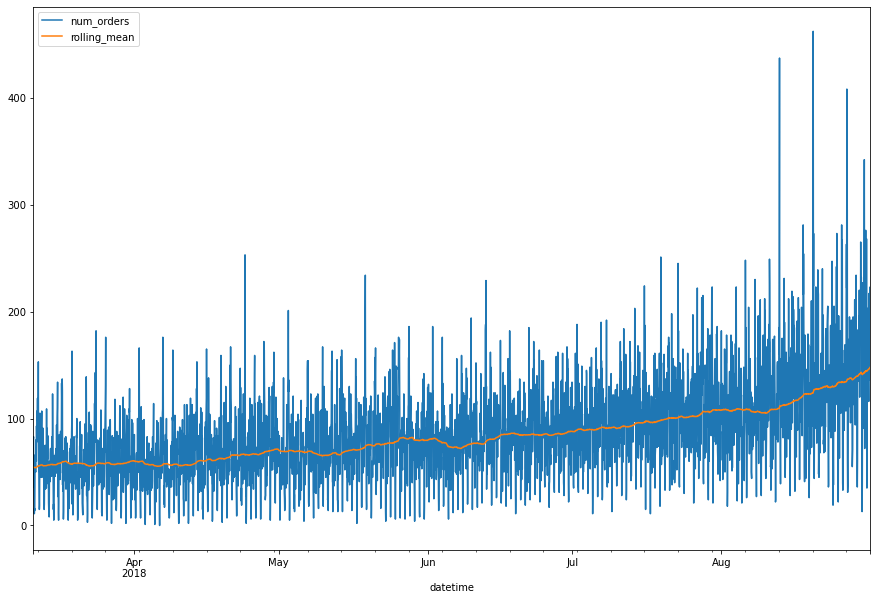

In [11]:
data.plot(y=['num_orders','rolling_mean'], figsize=(15,10))
data.shape

In [12]:
pm.arima.ndiffs(data['num_orders'])

1

In [13]:
pm.arima.ndiffs(data['num_orders'])

1

## Traininig

In [14]:
#Function to plot predicted vs actual values
def plot_predictions(predictions, actual, model_name, index_min=0, index_max=0):
    predictions = pd.DataFrame(predictions, index=actual.index)
    fig, ax = plt.subplots(figsize=(15,10))
    if index_min == 0:
        index_min=actual.index.min()
    if index_max == 0:
        index_max=actual.index.max()
    actual[index_min:index_max].plot(ax=ax, title=f'Actual and predicted number of orders, {model_name}')
    predictions[index_min:index_max].plot(ax=ax)
    ax.legend(['Actual', 'Predicted'])
    ax.grid(True)
    plt.show()

### Linear Regression Model

In [15]:
features = data.drop(['num_orders'], axis=1)
target = data['num_orders']
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)
features.shape

(4176, 28)

In [46]:
%%time

lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

CPU times: user 16.7 ms, sys: 7.07 ms, total: 23.7 ms
Wall time: 19.7 ms


LinearRegression()

RMSE of Linear Regression: 34.762386011996504


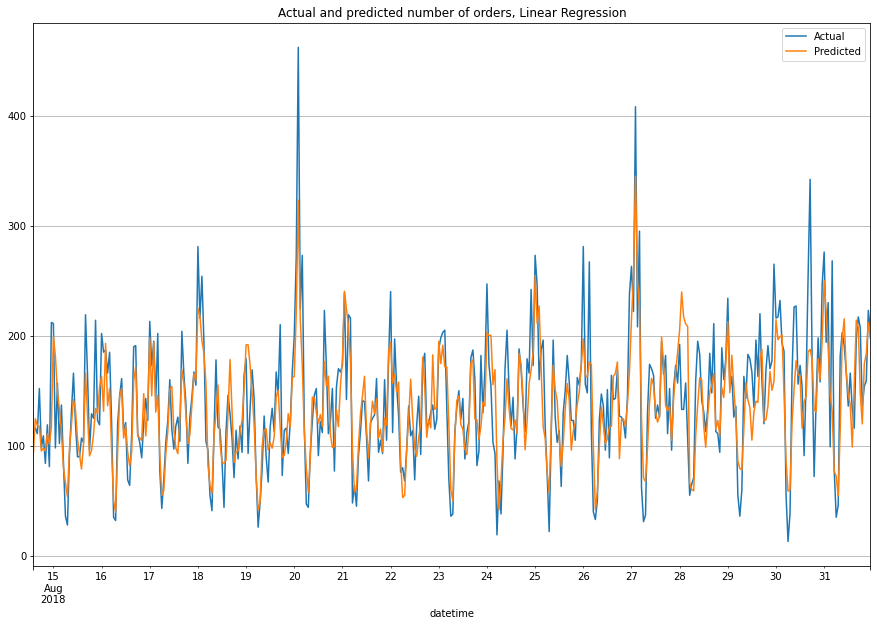

In [17]:
predictions = lr_model.predict(features_test)
print('RMSE of Linear Regression:', mean_squared_error(target_test, predictions)**0.5)
plot_predictions(predictions, target_test, 'Linear Regression')

### Random Forest Regressor

In [47]:
%%time

params = {'n_estimators': 20, 
         'max_depth': 10}
rfr = RandomForestRegressor(**params)
rfr.fit(features_train, target_train)

CPU times: user 674 ms, sys: 12.3 ms, total: 686 ms
Wall time: 702 ms


RandomForestRegressor(max_depth=10, n_estimators=20)

RMSE of RandomForest: 42.95547219752611


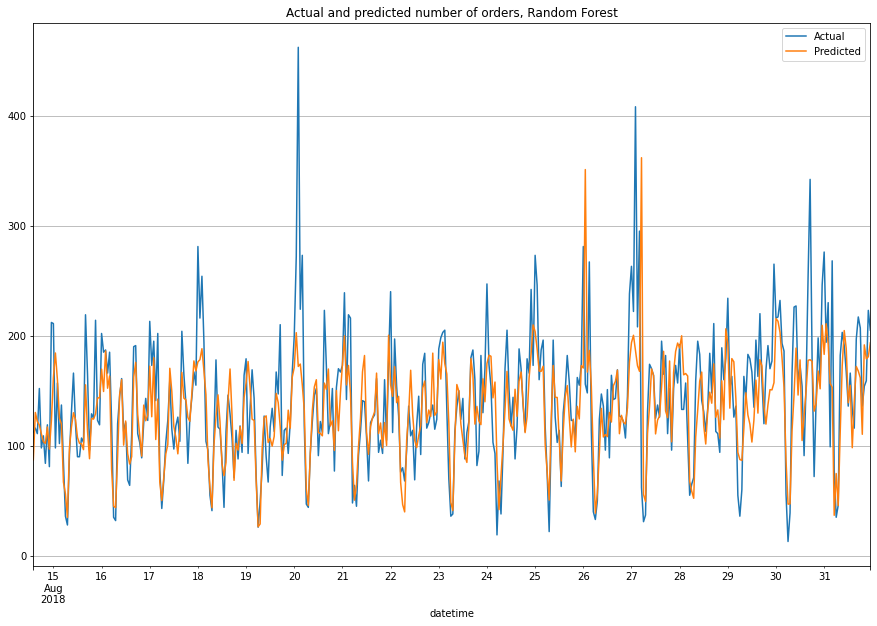

In [19]:
predictions = rfr.predict(features_test)
print('RMSE of RandomForest:', mean_squared_error(target_test, predictions)**0.5)
plot_predictions(predictions, target_test, 'Random Forest')

### CatBoost Regression

In [20]:
catboost_model = CatBoostRegressor(iterations=2000, learning_rate=0.05)
catboost_model.fit(features_train, target_train, verbose=100)

0:	learn: 37.8489843	total: 59.7ms	remaining: 1m 59s
100:	learn: 20.4734274	total: 345ms	remaining: 6.49s
200:	learn: 19.1160442	total: 590ms	remaining: 5.28s
300:	learn: 17.6785159	total: 901ms	remaining: 5.09s
400:	learn: 16.3955690	total: 1.15s	remaining: 4.58s
500:	learn: 15.2256862	total: 1.39s	remaining: 4.17s
600:	learn: 14.2317980	total: 1.62s	remaining: 3.78s
700:	learn: 13.2641935	total: 1.88s	remaining: 3.49s
800:	learn: 12.4025422	total: 2.13s	remaining: 3.2s
900:	learn: 11.6102958	total: 2.4s	remaining: 2.93s
1000:	learn: 10.8650598	total: 2.65s	remaining: 2.65s
1100:	learn: 10.2255042	total: 2.9s	remaining: 2.37s
1200:	learn: 9.6270663	total: 3.14s	remaining: 2.09s
1300:	learn: 9.0323924	total: 3.38s	remaining: 1.81s
1400:	learn: 8.5302417	total: 3.61s	remaining: 1.54s
1500:	learn: 8.0527021	total: 3.83s	remaining: 1.27s
1600:	learn: 7.6276877	total: 4.08s	remaining: 1.02s
1700:	learn: 7.2341711	total: 4.32s	remaining: 759ms
1800:	learn: 6.8324192	total: 4.55s	remaining: 

RMSE of Catboost: 41.41344778755094


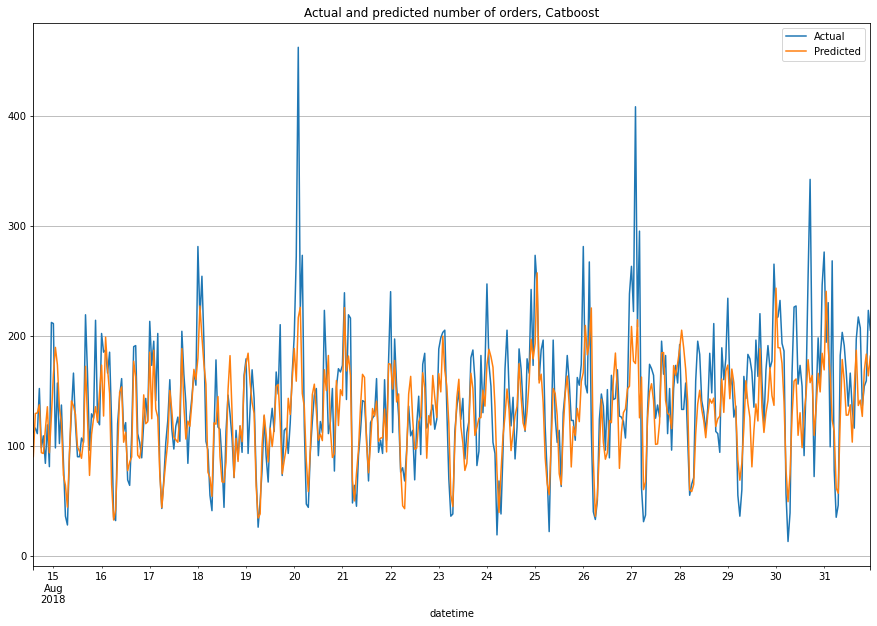

In [21]:
predictions = catboost_model.predict(features_test)
print('RMSE of Catboost:', mean_squared_error(target_test, predictions)**0.5)
plot_predictions(predictions, target_test, 'Catboost')

### SARIMA

In [22]:
#Prepare list of exogenous features for SARIMA fitting
exogenous_features = features_train[['dayofweek', 'lag_168']]
exogenous_features.head()

exogenous_test_features = features_test[['dayofweek', 'lag_168']]

In [23]:
%%time

sarima = pm.arima.AutoARIMA(start_p=0, start_q=0, d=1, max_p=2, max_q=2,
                     max_P=2, max_Q=2, max_D = 3, m=24, seasonal=True,  stepwise=True,
                     suppress_warnings=True, trace=True,
                     error_action='ignore', maxiter = 30)
sarima.fit(target_train[-3000:], X=exogenous_features[-3000:])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=6.19 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=29472.866, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=28723.332, Time=5.13 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=27802.362, Time=6.95 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=29470.866, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=27844.053, Time=1.37 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=13.02 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=27797.008, Time=28.92 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=40.24 sec
 ARIMA(0,1,0)(0,0,2)[24] intercept   : AIC=29403.638, Time=10.08 sec
 ARIMA(1,1,1)(0,0,2)[24] intercept   : AIC=inf, Time=23.55 sec
 ARIMA(0,1,2)(0,0,2)[24] intercept   : AIC=inf, Time=25.28 sec
 ARIMA(1,1,0)(0,0,2)[24] intercept   : AIC=28703.729, Time=19.87 sec
 ARIMA(1,1,2)(0,0,2)[24] intercept   : AIC=27770.801, Time=27.05 sec
 ARIMA(1,1,2)(0,0,1)[24] in

AutoARIMA(d=1, error_action='ignore', m=24, max_D=3, max_p=2, max_q=2,
          maxiter=30, start_p=0, start_q=0, trace=True)

In [24]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3000
Model:             SARIMAX(0, 1, 2)x(0, 0, 2, 24)   Log Likelihood              -13872.483
Date:                            Sun, 27 Feb 2022   AIC                          27758.965
Time:                                    01:30:15   BIC                          27801.008
Sample:                                04-11-2018   HQIC                         27774.088
                                     - 08-14-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dayofweek     -0.3220      0.242     -1.330      0.184      -0.797       0.153
lag_168        0.6550      0.013     51.248      0.000       0.630       0.680
ma.L1         -0.9079      0.014    -63.605      0.000      -0.936      -0.880
ma.L2         -0.0669      0.015     -4.565      0.000      -0.096      -0.038
ma.S.L24       0.1227      0.015      8.089      0.000       0.093       0.152
ma.S.L48       0.1189      0.017      6.904      0.000       0.085       0.153
sigma2       610.1597      7.899     77.247      0.000     594.678     625.641
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             15631.53
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                             1.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

As you can see, the sign with a lag of 168 hours is taken into account with a negligible coefficient.

In [25]:
predictions = sarima.predict(n_periods = target_test.shape[0], X=exogenous_test_features)

In [26]:
target_test.head()

datetime
2018-08-14 14:00:00    112
2018-08-14 15:00:00    116
2018-08-14 16:00:00    111
2018-08-14 17:00:00    152
2018-08-14 18:00:00     98
Freq: H, Name: num_orders, dtype: int64

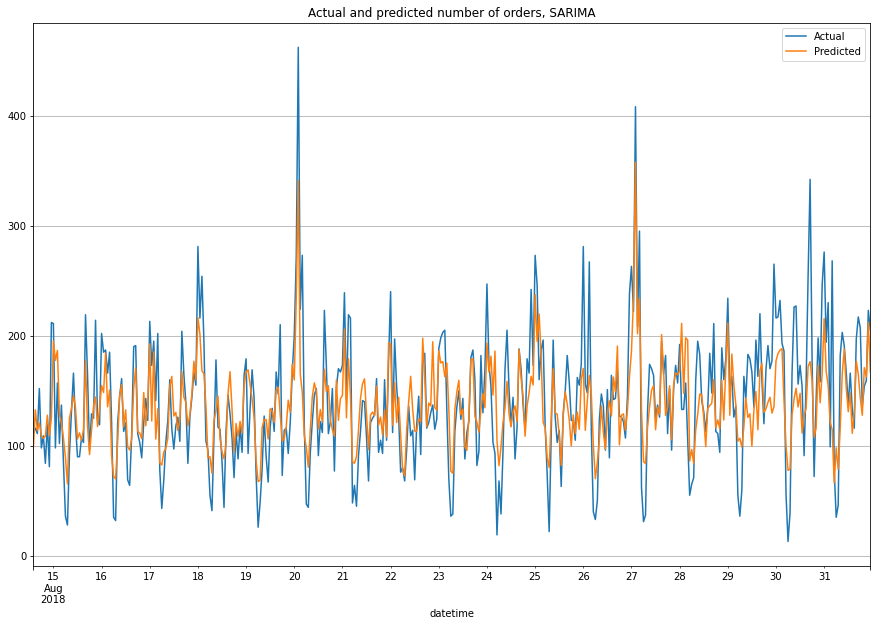

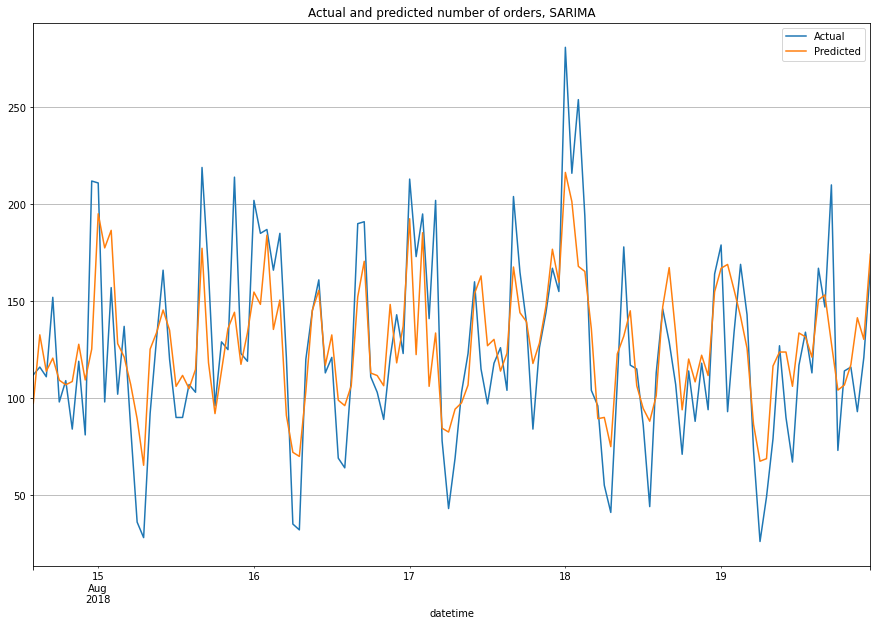

In [27]:
plot_predictions(predictions, target_test, 'SARIMA')
plot_predictions(predictions, target_test, 'SARIMA', index_max='2018-08-19')

One of the features of the (S)ARIMA model is that adequate predictions on it can be obtained only on a small horizon of periods, in our case, about 20 steps ahead. Since (S)ARIMA must be trained on the time series preceding the prediction, in order to generate predictions on the entire test set, it will be necessary to run several cycles of retraining and prediction for the next horizon, in each cycle adding the previous batch of records with correct values from test sample.

Now let's try to train the model without using a sample with external features, but by increasing the seasonality parameter **m** to 84. To speed up AutoARIMA, we will use regular ARIMA with fixed values of hyperparameters that AutoARIMA defined above.

In [30]:
%%time

sarima = pm.ARIMA(order=(1,1,2), seasonal_order=(2, 0, 0, 84))
sarima.fit(target_train[-2000:])

CPU times: user 14min 12s, sys: 9.22 s, total: 14min 21s
Wall time: 3min 56s


ARIMA(order=(1, 1, 2), seasonal_order=(2, 0, 0, 84))

In [31]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2000
Model:             SARIMAX(1, 1, 2)x(2, 0, [], 84)   Log Likelihood               -9476.369
Date:                             Sun, 27 Feb 2022   AIC                          18966.738
Time:                                     01:40:00   BIC                          19005.941
Sample:                                          0   HQIC                         18981.133
                                            - 2000                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0103      0.002      4.947      0.000       0.006       0.014
ar.L1         -0.9614      0.028    -34.543      0.000      -1.016      -0.907
ma.L1         -0.0262      0.024     -1.098      0.272      -0.073       0.021
ma.L2         -0.9734      0.025    -39.212      0.000      -1.022      -0.925
ar.S.L84       0.0093      0.018      0.529      0.597      -0.025       0.044
ar.S.L168      0.7235      0.015     47.674      0.000       0.694       0.753
sigma2       719.7827     11.690     61.570      0.000     696.870     742.696
===================================================================================
Ljung-Box (L1) (Q):                  32.38   Jarque-Bera (JB):             13006.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             1.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
%%time

PERIODS=20
predictions, conf_int = sarima.predict(n_periods = PERIODS, return_conf_int=True)
#print(target_test[:10])
#i=1
#print(target_test[10*(i-1):10*i])
print(predictions)
for i in range(1, target_test.shape[0] // PERIODS):
    print(f"Iteration {i} of {target_test.shape[0] // PERIODS}")
    sarima.update(target_test[PERIODS*(i-1):PERIODS*i])
    new_predictions, new_conf_int = sarima.predict(n_periods = PERIODS, return_conf_int=True)
    predictions = np.append(predictions, new_predictions)
    conf_int = np.append(conf_int, new_conf_int)
    if (i == (target_test.shape[0] // PERIODS) - 1) & (target_test.shape[0] % PERIODS > 0):
        sarima.update(target_test[-(target_test.shape[0] % PERIODS):])
        new_predictions, new_conf_int = sarima.predict(n_periods = target_test.shape[0] % PERIODS, return_conf_int=True)
        predictions = np.append(predictions, new_predictions)
        conf_int = np.append(conf_int, new_conf_int)

[ 90.35713917 113.19092043 107.85004466 105.03371855  96.21826063
  96.29149422  98.73496261 105.91607748  98.21870777 107.12583854
 201.59193991 143.88190324 148.77620876 108.64966545 111.28384041
  95.53200173  78.33215065  52.75219574 116.81360172 121.60277321]
Iteration 1 of 20
Iteration 2 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 3 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 4 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 5 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 6 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 7 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 8 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 9 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 10 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 11 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 12 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 13 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 14 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 15 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 16 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 17 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 18 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Iteration 19 of 20


/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/vasily/opt/anaconda3/envs/praktikum/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



CPU times: user 1h 9min 46s, sys: 2min 30s, total: 1h 12min 17s
Wall time: 20min 44s


In [40]:
#print(predictions)
#print(len(target_test))
#print(conf_int)

RMSE of SARIMA: 39.304542957248145


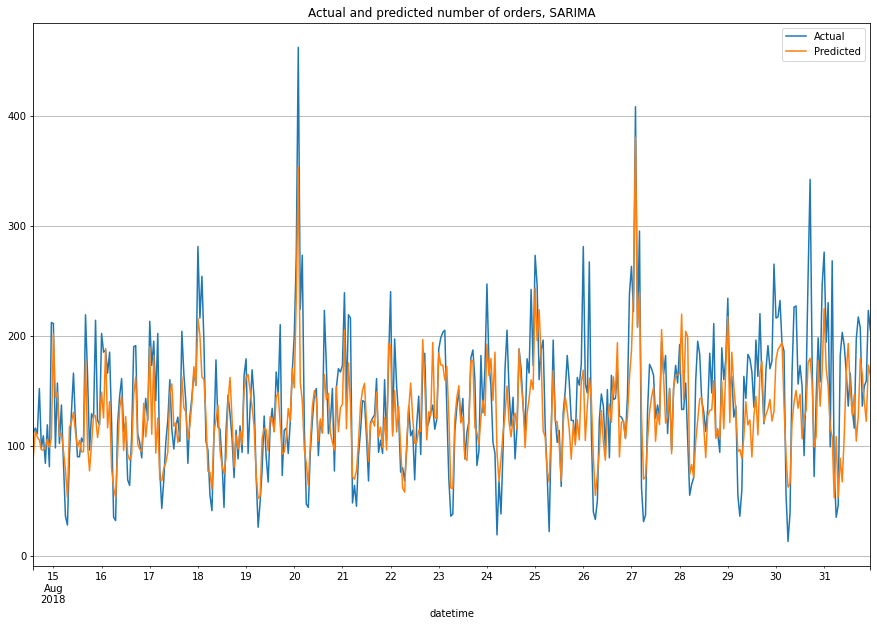

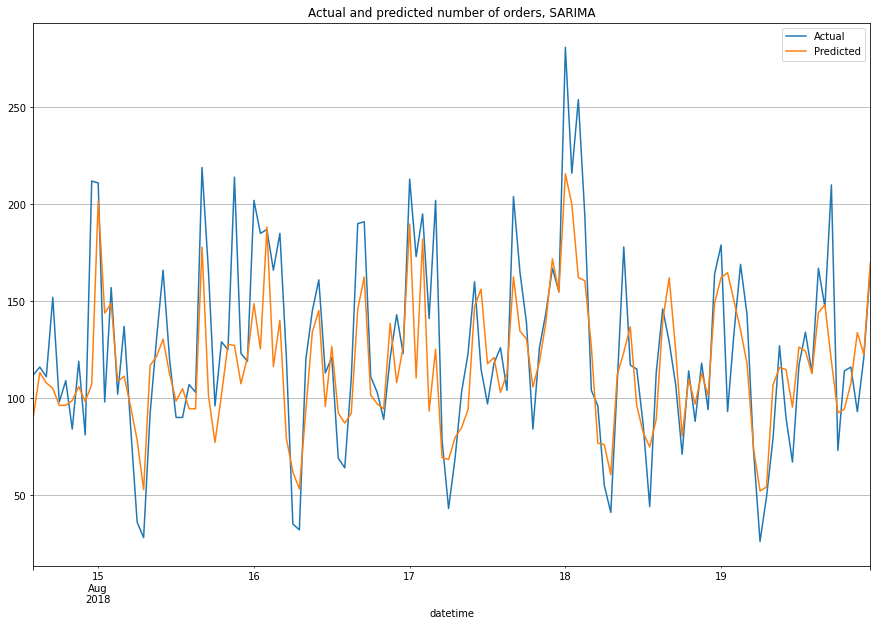

In [34]:
print('RMSE of SARIMA:', mean_squared_error(target_test, predictions)**0.5)
plot_predictions(predictions, target_test, 'SARIMA')
plot_predictions(predictions, target_test, 'SARIMA', index_max='2018-08-19')

### Prophet

In [41]:
#Adapt data for Prophet
target_train_prophet = target_train.reset_index().rename(columns = {'datetime': 'ds', 'num_orders': 'y'})
print(target_train_prophet.head())
future = target_test.reset_index().drop('num_orders', axis=1).rename(columns = {'datetime': 'ds'})
print(future.head())

                   ds   y
0 2018-03-11 00:00:00  81
1 2018-03-11 01:00:00  83
2 2018-03-11 02:00:00  36
3 2018-03-11 03:00:00  49
4 2018-03-11 04:00:00  30
                   ds
0 2018-08-14 14:00:00
1 2018-08-14 15:00:00
2 2018-08-14 16:00:00
3 2018-08-14 17:00:00
4 2018-08-14 18:00:00


In [48]:
%%time

prophet = Prophet(daily_seasonality=True, weekly_seasonality=True)
prophet.add_country_holidays(country_name='RU')
prophet.fit(target_train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


CPU times: user 1.87 s, sys: 76.2 ms, total: 1.95 s
Wall time: 2.03 s


In [ ]:
#prophet.train_holiday_names

In [43]:
predictions = prophet.predict(future)

In [ ]:
#predictions.head()

In [44]:
predictions2 = predictions[['ds', 'yhat']].rename(columns = {'ds': 'datetime', 'yhat': 'num_orders'})
predictions2 = predictions2.set_index('datetime')

RMSE of Prophet: 48.256096511460285


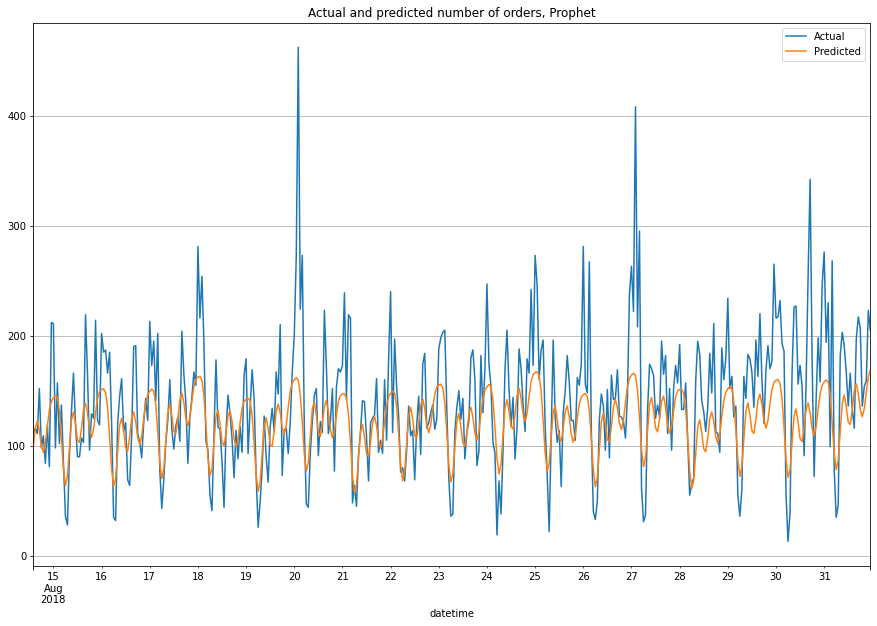

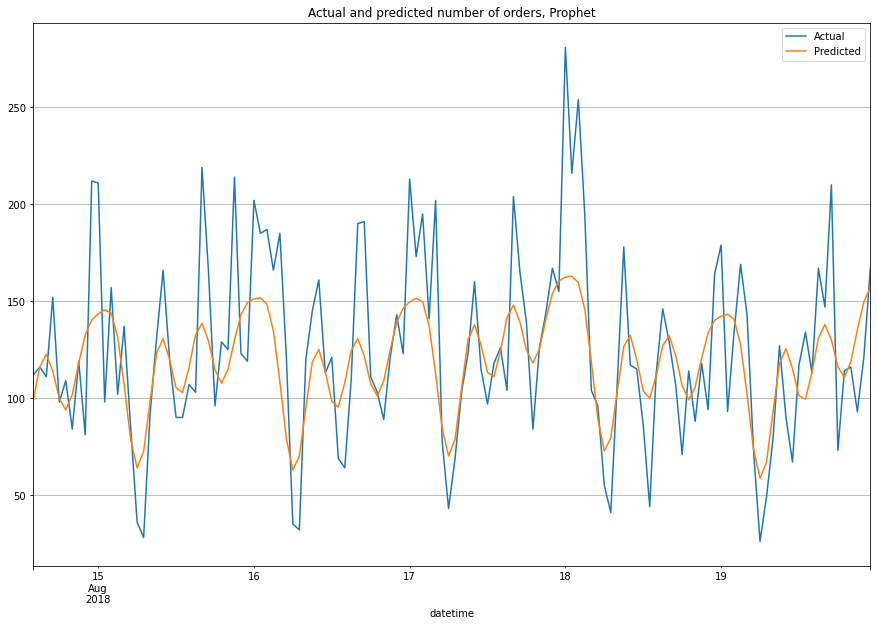

In [45]:
print('RMSE of Prophet:', mean_squared_error(target_test, predictions2)**0.5)
plot_predictions(predictions2, target_test, 'Prophet')
plot_predictions(predictions2, target_test, 'Prophet', index_max='2018-08-19')

## Comparison of Models

In [50]:
table = [{'Model': 'Linear Regression', 'RMSE': 34.8, 'Training Time (Wall time)': '20ms'},
         {'Model': 'SARIMA', 'RMSE': 39.3, 'Training Time (Wall time)': '42min'},
         {'Model': 'Catboost', 'RMSE': 41.4, 'Training Time (Wall time)': '5s'},
         {'Model': 'Random Forest', 'RMSE': 43.9, 'Training Time (Wall time)': '700ms'},
         {'Model': 'Prophet', 'RMSE': 48.2, 'Training Time (Wall time)': '2s'}
        ]
pd.DataFrame(data=table).set_index('Model')

,RMSE,Training Time (Wall time)
Model,,
Linear Regression,34.8,20ms
SARIMA,39.3,42min
Catboost,41.4,5s
Random Forest,43.9,700ms
Prophet,48.2,2s


The linear regression model showed the highest accuracy and at the same time instantaneous learning. SARIMA took the longest to train and is the most demanding on memory resources, while showing unimpressive accuracy. Apparently, SARIMA is not the best choice for time series with a pronounced seasonality pattern.
Catboost showed the third result.